In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-12-11 09:45:24--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.98.64, 52.217.138.80, 52.216.59.224, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.98.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  63.8MB/s    in 0.2s    

2023-12-11 09:45:24 (63.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
import numpy as np

from matplotlib import pyplot as plt

from tensorflow import keras
from keras import layers

In [3]:
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [8]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 122s 139ms/step - loss: 42.8754 - mae: 4.7738 - val_loss: 12.9973 - val_mae: 2.7401
Epoch 2/10
819/819 [==============================] - 113s 137ms/step - loss: 11.2063 - mae: 2.6003 - val_loss: 9.7867 - val_mae: 2.4211
Epoch 3/10
819/819 [==============================] - 128s 155ms/step - loss: 9.8444 - mae: 2.4532 - val_loss: 9.7183 - val_mae: 2.4088
Epoch 4/10
819/819 [==============================] - 125s 153ms/step - loss: 9.3753 - mae: 2.3899 - val_loss: 9.8589 - val_mae: 2.4239
Epoch 5/10
819/819 [==============================] - 126s 153ms/step - loss: 9.0798 - mae: 2.3489 - val_loss: 9.7490 - val_mae: 2.4155
Epoch 6/10
819/819 [==============================] - 130s 158ms/step - loss: 8.8361 - mae: 2.3154 - val_loss: 9.5463 - val_mae: 2.3904
Epoch 7/10
819/819 [==============================] - 126s 153ms/step - loss: 8.6616 - mae: 2.2943 - val_loss: 9.5619 - val_mae: 2.3952
Epoch 8/10
819/819 [=========================

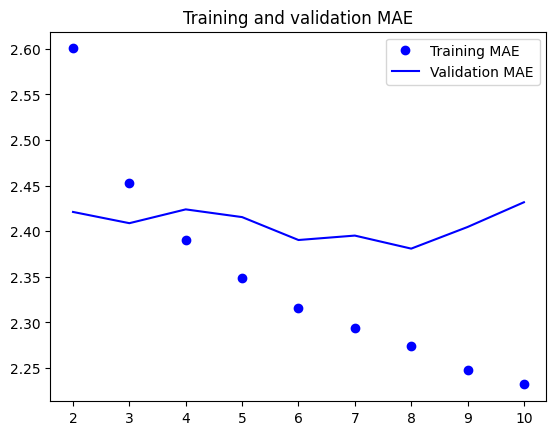

In [12]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(2, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss[1:], "bo", label="Training MAE")
plt.plot(epochs, val_loss[1:], "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()